# **Classification of the "Intel Image Classification" Dataset**

We Start by importing the needed libraries

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
from time import perf_counter

from random import randint as rand
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torchvision.transforms import v2
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Dataset processing

In [3]:
path = Path("./Data/seg_train/seg_train")

In [4]:
# Create a dictionnary to map the classes to integers by using the folder names

targets_labels = {folder.name: i for i, folder in enumerate(path.iterdir())}

In [5]:
targets_labels

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [6]:
def load_data(path):
    imgs = []
    targets = []
    
    for folder in path.iterdir():
        for file in folder.iterdir():
            imgs.append(v2.Resize((150,150))(read_image(str(file))))
            targets.append(folder.name)
    imgs = torch.stack(imgs)
    targets = torch.tensor([targets_labels[t] for t in targets])
    
    return imgs, targets

In [7]:
train_imgs, train_targets = load_data(path)

In [8]:
print(train_targets)

tensor([0, 0, 0,  ..., 5, 5, 5])


In [9]:
target_dict = np.unique(train_targets)

In [10]:
class ImageDataset(Dataset):
    def __init__(self, img, targets):
        self.img = img.clone().detach().to(device).to(torch.float32)
        self.targets = targets.clone().detach().to(device).to(torch.float32)

    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        img = self.img[idx]
        target = self.targets[idx]
        return img, target

In [11]:
train_data = ImageDataset(train_imgs, train_targets)

In [13]:
train_imgs.shape

torch.Size([14034, 3, 150, 150])

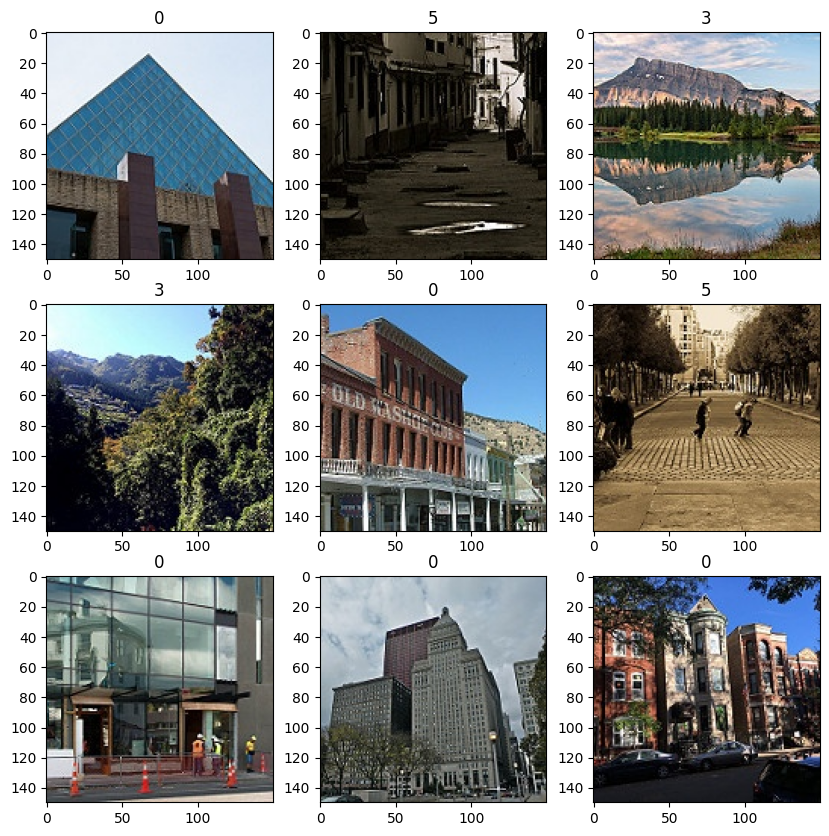

In [14]:
fig = plt.figure(figsize=(10, 10))
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    r = rand(0, len(train_imgs))
    ax.imshow(v2.ToPILImage()(train_imgs[r]))
    ax.set_title(target_dict[train_targets[r]])

In [16]:
train_targets[r]

tensor(0)

Data targets:

0. buildings
1. forest
2. glacier
3. mountain
4. sea
5. street

## Model creation

In [17]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # Input size - Kernel size / Stride + 1 = Output size (6,146,146)
        self.pool = nn.MaxPool2d(2, 2) # Divide the size by 2 (6,73,73)
        self.conv2 = nn.Conv2d(6, 16, 5) # (16,69,69) -> (16,34,34) (Because of the pooling layer (again)) -> Flatten (16*34*34) = 18496
        
        #Dense layers
        
        self.fc1 = nn.Linear(16 * 34 * 34, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [18]:
model = Model()
model.to(device)

Model(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=18496, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=6, bias=True)
)

In [19]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

In [20]:
train_data.img.dtype

torch.float32

In [21]:
train_data.targets.dtype

torch.float32

## Training loop

In [22]:
loader = DataLoader(train_data, batch_size=16, shuffle=True)

epoch = 50
def train_loop(loader, model, criterion, optimizer):
    for e in range(epoch):
        start_time = perf_counter()
        for i, (train_img, target) in enumerate(loader):
            target = target.long()
            optimizer.zero_grad()
            output = model(train_img)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        end_time = perf_counter()
        print(f"Epoch: {e}, Loss: {loss}, Time: {end_time - start_time:.2f} s")

In [23]:
train_loop(loader, model, criterion, optimizer)

Epoch: 0, Loss: 1.6702301502227783, Time: 4.26 s
Epoch: 1, Loss: 0.06867270171642303, Time: 3.30 s
Epoch: 2, Loss: 0.250942587852478, Time: 3.29 s
Epoch: 3, Loss: 0.08710060268640518, Time: 3.29 s
Epoch: 4, Loss: 0.7789719700813293, Time: 3.28 s
Epoch: 5, Loss: 0.14944714307785034, Time: 3.29 s
Epoch: 6, Loss: 0.02430480159819126, Time: 3.30 s
Epoch: 7, Loss: 0.08807850629091263, Time: 3.25 s
Epoch: 8, Loss: 0.0012864535674452782, Time: 3.25 s
Epoch: 9, Loss: 0.0017544873990118504, Time: 3.28 s
Epoch: 10, Loss: 7.14608613634482e-05, Time: 3.30 s
Epoch: 11, Loss: 0.28914427757263184, Time: 3.31 s
Epoch: 12, Loss: 0.00017616216791793704, Time: 3.26 s
Epoch: 13, Loss: 0.07061900198459625, Time: 3.26 s
Epoch: 14, Loss: 0.001446524285711348, Time: 3.21 s
Epoch: 15, Loss: 0.0011819923529401422, Time: 3.19 s
Epoch: 16, Loss: 0.001292763277888298, Time: 3.20 s
Epoch: 17, Loss: 5.274762224871665e-05, Time: 3.22 s
Epoch: 18, Loss: 0.0012304268311709166, Time: 3.25 s
Epoch: 19, Loss: 0.0001120503

In [24]:
def predict(img):
    return target_dict[torch.argmax(model(img)).item()]

In [25]:
path = Path("./Data/seg_test/seg_test")

test_imgs, test_targets = load_data(path)

In [27]:
test_data = ImageDataset(test_imgs, test_targets)

In [32]:
def accruacy_calc():
    preds = []
    for img in test_data.img:
        preds.append(predict(img.unsqueeze(0)))
    accuracy = sum([1 for i in range(len(preds)) if preds[i] == target_dict[int(test_data.targets[i])]])/len(preds)*100
    return accuracy

In [33]:
accuracy

74.33333333333333